In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!python3 -m pip install -U pygame==1.9.3

     |████████████████████████████████| 9.4MB 5.4MB/s 
  Found existing installation: pygame 1.9.6
    Uninstalling pygame-1.9.6:
      Successfully uninstalled pygame-1.9.6


In [ ]:
!git clone https://github.com/ntasfi/PyGame-Learning-Environment.git

fatal: destination path 'PyGame-Learning-Environment' already exists and is not an empty directory.


In [ ]:
%cd /content/PyGame-Learning-Environment
!pip install -e .

/content/PyGame-Learning-Environment
Obtaining file:///content/PyGame-Learning-Environment
  Found existing installation: ple 0.0.1
    Can't uninstall 'ple'. No files were found to uninstall.
  Running setup.py develop for ple


In [ ]:
import os
os.putenv('SDL_VIDEODRIVER', 'fbcon')
os.environ["SDL_VIDEODRIVER"] = "dummy"

from ple.games.pong import Pong
import pygame
from ple import PLE

In [ ]:
# Setting up the game environment and getting the list of possible actions
game = Pong(width=64, height=64)
p = PLE(game, fps=30, display_screen=False, force_fps=False)
action_set = p.getActionSet()

couldn't import doomish
Couldn't import doom


In [ ]:
# the agent() and trail() functions for generating the frames
# One player is CPU and the other player is a random agnet
import random
from copy import deepcopy
import numpy as np


NB_FRAMES = 1000
NB_TRAILS = 200
DIR_NAME = '/content/drive/MyDrive/PONG_Data_large_ball_pad_random_agent'

def agent(action_set):
  return random.choice(action_set)

def trail(nb_frames, p, action_set):
  obs_w_p = []
  # obs_o_p = []
  for f in range(nb_frames):
    if p.game_over():
      p.reset_game()
    frame_w_p = p.getScreenGrayscale() # getting gray scale frames
    obs_w_p.append(frame_w_p)

    # removing paddles (this only works when the paddles were small)
    # frame_o_p = deepcopy(frame_w_p)
    # frame_o_p[4, 27:37] = 0 
    # frame_o_p[60, :] = 0
    # obs_o_p.append(frame_o_p)

    action = agent(action_set)
    r = p.act(action)
  return obs_w_p #, obs_o_p

# For running one trial
# p.init()
# obs_w_p, obs_o_p = trail(NB_FRAMES, p)
# recording_obs_w_p = np.array(obs_w_p, dtype=np.uint8)
# recording_obs_o_p = np.array(obs_o_p, dtype=np.uint8)

# For running multiple trails
for nt in range(NB_TRAILS):
    random_generated_int = random.randint(0, 2**31-1)
    filename = DIR_NAME+"/"+str(random_generated_int)+".npz"
    p.init()
    obs_w_p = trail(NB_FRAMES, p, action_set)
    recording_obs_w_p = np.array(obs_w_p, dtype=np.uint8)
    np.savez_compressed(filename, obs_w_p=recording_obs_w_p)

    # For when I was zeroing out the small paddles
    # obs_w_p, obs_o_p = trail(NB_FRAMES, p)
    # recording_obs_w_p = np.array(obs_w_p, dtype=np.uint8)
    # recording_obs_o_p = np.array(obs_o_p, dtype=np.uint8)
    # np.savez_compressed(filename, obs_w_p=recording_obs_w_p, obs_o_p=recording_obs_o_p)

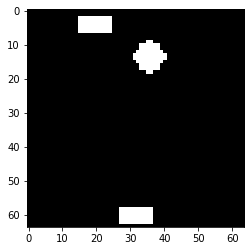

In [ ]:
# For animating the frames
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def animate(frames, anim_name):
  fig = plt.figure('fig')
  imgs = [[plt.imshow(f, cmap='gray')] for f in frames]
  anim = animation.ArtistAnimation(fig, imgs, interval = 30, blit = True, repeat_delay=0)
  anim.save('{}.mp4'.format(anim_name))

animate(obs_w_p, 'trail_w_p.mp4') # Animating one of the trials

In [ ]:
# For extracting the paddles from the frames
from copy import deepcopy

def extract_pad(f):
  frames = deepcopy(f)
  for i in range(np.shape(frames)[0]):
    pad_sum = np.sum(frames[i], axis = 0)
    pad_sum_5 = np.where(np.sum(frames[i], axis = 0) == 5)[0] # 5 is paddle height
    idx = []
    for j in range(np.shape(pad_sum_5)[0] - 1):
      if pad_sum_5[j + 1] == pad_sum_5[j] + 1:
        idx.append(pad_sum_5[j])
      else:
        if len(idx) > 8: # A threshold, should be a portion of the paddle length (here paddle length is 10)
          break
        else:
          idx = []
    while len(idx) < 10: # paddle length
      if idx[-1] < 63:  # frame width
        if pad_sum[idx[-1] + 1] > 0:
          idx.append(idx[-1] + 1)
        else:
          idx.insert(0,idx[0] - 1)
    frames[i, :, [k for k in range(np.shape(frames)[2]) if k not in idx]] = 0
  return frames

In [ ]:
# Using the extract_pad() function to extract the pads in separate frames, and trimming the frames to include only the ball
import numpy as np
import os

DATA_DIR = '/content/gdrive/MyDrive/PONG_Data_large_ball_pad_random_agent'
NEW_DIR = '/content/gdrive/MyDrive/PONG_Data_ball_pads_seperated'


filelist = os.listdir(DATA_DIR)
for f in filelist:
  data = np.load(DATA_DIR + '/' + f)
  game_frames = data['obs_w_p']
  game_frames = game_frames/255.0
  ball_frames = np.zeros_like(game_frames[1:, 7:58, :]) # drop the first frame 
  ball_frames[:,: ,:] = game_frames[1:,7:58,:] 

  # Extracting upper pads
  upper_pads = np.zeros_like(ball_frames) 
  upper_pads[:, 2:7,:] = game_frames[1:, 2:7,:] 
  upper_pads_o_b = extract_pad(upper_pads)

  # Extracting lower pads
  lower_pads = np.zeros_like(ball_frames)
  lower_pads[:, 45:50, :] = game_frames[1:, 58:63, :]
  lower_pads_o_b = extract_pad(lower_pads)

  # Stroing everything in a new directory
  np.savez_compressed(NEW_DIR + '/' + f, ball = ball_frames, u_pad=upper_pads_o_b,\
                      l_pad = lower_pads_o_b, whole_frames = game_frames[1:, :, :])

(999, 64, 64)


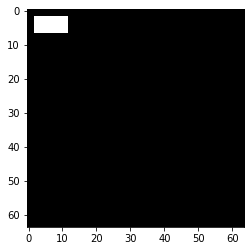

In [ ]:
# Animating one trail of only upper paddle
DATA_DIR = '/content/gdrive/MyDrive/PONG_Data_large_ball_pad_random_agent'

filelist = os.listdir(DATA_DIR)
filelist.sort()
filelist = filelist[199]

data = np.load(DATA_DIR + '/' + filelist)
game_frames = data['obs_w_p']

upper_pads = np.zeros_like(game_frames[1:,7:58,:]) # drop the first frame 
upper_pads[:, 2:7,:] = game_frames[1:, 2:7,:] 
upper_pads_o_b = extract_pad(upper_pads)

animate(upper_pads_o_b, 'u_pad')

(999, 64, 64)


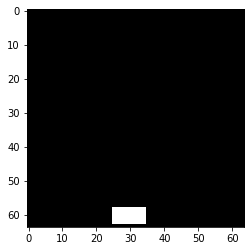

In [ ]:
# Animating one trail of only lower paddle
DATA_DIR = '/content/gdrive/MyDrive/PONG_Data_large_ball_pad_random_agent'

filelist = os.listdir(DATA_DIR)
filelist.sort()
filelist = filelist[199]

data = np.load(DATA_DIR + '/' + filelist)
game_frames = data['obs_w_p']

lower_pads = np.zeros_like(game_frames[1:,7:58,:])
lower_pads[:, 45:50, :] = game_frames[1:, 58:63, :]
lower_pads_o_b = extract_pad(lower_pads)

animate(upper_pads_o_b, 'l_pad')

In [3]:
!git clone https://github.com/hardmaru/WorldModelsExperiments.git

Cloning into 'WorldModelsExperiments'...
remote: Enumerating objects: 200, done.
remote: Total 200 (delta 0), reused 0 (delta 0), pack-reused 200
Receiving objects: 100% (200/200), 21.00 MiB | 20.95 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [1]:
%cd /content/WorldModelsExperiments/carracing

/content/WorldModelsExperiments/carracing


In [2]:
%tensorflow_version 1.8.0 # Change the tensorflow default to 1.x

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.8.0 # Change the tensorflow default to 1.x`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
# Use the frames with large ball and zeroed out paddles to train a VAE

########### Attention! ###########
#change 3 to 1 (3 -> 1) in line 34 and 56 in WorldModelsExperiments/carracing/vae.py 
# after git clone (before running this cell)

# Also beta needs to be added to the world models VAE implementation
# in /content/WorldModelsExperiments/carracing/vae/vae.py file:

# line 14 add: , beta = 1
# afer line 20 add: self.beta = beta
# considering a line was added for beta, change the current line 80 to self.loss = self.r_loss + self.beta * self.kl_loss
#################################

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # can just override for multi-gpu systems

import tensorflow as tf
import random
import numpy as np
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)
from tqdm import tqdm
from vae.vae import ConvVAE, reset_graph

# Hyperparameters for ConvVAE
z_size=2
batch_size=100
learning_rate=0.0001
kl_tolerance=0.5
beta = 50
# Parameters for training
NUM_EPOCH = 50
DATA_DIR = '/content/gdrive/MyDrive/PONG_Data_large_ball'

model_save_path = '/content/gdrive/MyDrive/PONG_model'
if not os.path.exists(model_save_path):
  os.makedirs(model_save_path)

def create_dataset(filelist, N=199): # N is 199 episodes
  data = []
  for i in range(N):
    filename = filelist[i]
    raw_data = np.load(os.path.join(DATA_DIR, filename))['obs_o_p']
    raw_data_o_0 = [d for d in raw_data if np.sum(d) != 0]
    data += raw_data_o_0
  return np.expand_dims(np.asarray(data, dtype=np.uint8), -1)

filelist = os.listdir(DATA_DIR)
filelist.sort()
filelist = filelist[0:199]

dataset = create_dataset(filelist)

# split into batches:
total_length = len(dataset)
num_batches = int(np.floor(total_length/batch_size))
print("num_batches", num_batches)

reset_graph()

vae = ConvVAE(z_size=z_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              kl_tolerance=kl_tolerance,
              is_training=True,
              reuse=False,
              gpu_mode=True,
              beta= beta)

# train loop:
print("train", "step", "loss", "recon_loss", "kl_loss")
for epoch in tqdm(range(NUM_EPOCH)):
  np.random.shuffle(dataset)
  for idx in range(num_batches):
    batch = dataset[idx*batch_size:(idx+1)*batch_size]

    obs = batch.astype(np.float)

    feed = {vae.x: obs,}

    (train_loss, r_loss, kl_loss, train_step, _) = vae.sess.run([
      vae.loss, vae.r_loss, vae.kl_loss, vae.global_step, vae.train_op
    ], feed)
  
    if ((train_step+1) % 500 == 0):
      print("step", (train_step+1), train_loss, r_loss, kl_loss)
    if ((train_step+1) % 5000 == 0):
      vae.save_json( model_save_path + "/vae_pong_ne_{ne}_64x64_{beta}.json".format(ne = NUM_EPOCH, beta = beta))

# finished, final model:
vae.save_json(model_save_path + "/vae_pong_ne_{ne}_64x64_{beta}.json".format(ne = NUM_EPOCH, beta = beta))


num_batches 1988



INFO:tensorflow:Model using gpu.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





  0%|          | 0/50 [00:00<?, ?it/s]

train step loss recon_loss kl_loss
step 500 6262722.5 6262487.5 4.6980124
step 1000 6273206.5 6273009.5 3.9401045
step 1500 6420141.0 6419903.5 4.7538533


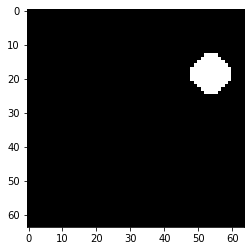

In [4]:
# Taking a frame from test frames for recounstruction
import os
import numpy as np
import matplotlib.pyplot as plt
DATA_DIR = '/content/gdrive/MyDrive/PONG_Data_large_ball'

filelist = os.listdir(DATA_DIR)
filelist.sort()
filelist = filelist[199]

data = np.load(DATA_DIR + '/' + filelist)
game_frames = data['obs_o_p']
game_frames = game_frames.astype(np.float32)
frame = game_frames[296]
plt.imshow(frame, cmap='gray')
plt.show()

In [5]:
# Load the VAE for test
from vae.vae import ConvVAE, reset_graph
import os
import numpy as np

z_size = 2
model_path_name = '/content/gdrive/MyDrive/PONG_model'
vae = ConvVAE(z_size=z_size,
              batch_size=1,
              is_training=False,
              reuse=False,
              gpu_mode=False, beta = 1)

vae.load_json(os.path.join(model_path_name, 'vae_pong_ne_50_64x64_100.json'))

INFO:tensorflow:Model using cpu.


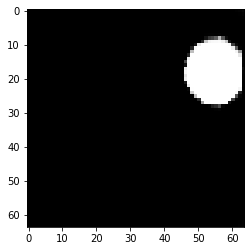

In [6]:
# frame reconstruction
batch_z = vae.encode(np.expand_dims(np.expand_dims(frame, 2), 0))
reconstruct = vae.decode(batch_z)
plt.imshow(np.squeeze(reconstruct[0]), cmap='gray')
plt.show()

64


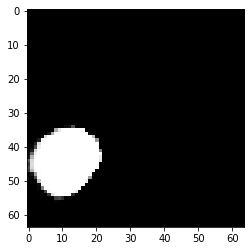

In [7]:
# Animating the reconstructed frame when changing the Z space in a range
# Note that no input is required for this part, only compiling the model and 
# loading the trained weights is required. The Z values will be selected from the 
# specified range 
from itertools import product
import matplotlib.animation as animation
import numpy as np

step1 = np.arange(-2, 2, 0.5)
step2 = np.arange(-2, 2, 0.5)
# print(len(steps))
xy = list(product(step1, step2)) # making a grid
print(len(xy))

fig = plt.figure('o_p')
img_rec = []
for item in xy:
  batch_z = np.expand_dims(np.asarray(item), 0)
  reconstruct = vae.decode(batch_z)
  img_rec.append([plt.imshow(np.squeeze(reconstruct[0]), cmap='gray')])

anim = animation.ArtistAnimation(fig, img_rec, interval = 30, blit = True, repeat_delay=0)
anim.save('rec_ball.mp4')

In [8]:
# ploting the outputs of the obove cell in a grid of images
import matplotlib.pyplot as plt

rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False}
plt.rcParams.update(rc)

fig, axs = plt.subplots(nrows = 8, ncols = 8, figsize = (15, 15))
axs = axs.ravel()
for i in range(len(xy)):
  batch_z = np.expand_dims(np.asarray(xy[i]), 0)
  # reconstruct = vae.decode(batch_z)
  axs[i].imshow(np.squeeze(vae.decode(batch_z)), cmap = 'gray')
fig.savefig('z_explore_beta_100_ne_50.pdf', bbox_inches='tight')
plt.close()